# Data Exploartion

In [ ]:
DATA_DIR: str = "/home/beckett/Documents/k0d1ng/pinn-bcd/kaggle/data/cbis-ddsm-breast-cancer-image-dataset"
CSV_DIR: str = DATA_DIR + "/csv"
JPEG_DIR: str = DATA_DIR + "/jpeg"

In [ ]:

DICOM_PATH: str = CSV_DIR + "/dicom_info.csv"
META_PATH: str = CSV_DIR + "/meta.csv"
MASS_TRAIN_PATH: str = CSV_DIR + "/mass_case_description_train_set.csv"
CALC_TRAIN_PATH: str = CSV_DIR + "/calc_case_description_train_set.csv"
MASS_TEST_PATH: str = CSV_DIR + "/mass_case_description_test_set.csv"
CALC_TEST_PATH: str = CSV_DIR + "/calc_case_description_test_set.csv"

In [19]:
import pandas as pd

df_mass = pd.read_csv(MASS_TRAIN_PATH)
df_calc = pd.read_csv(CALC_TRAIN_PATH)
df_dicom = pd.read_csv(DICOM_PATH)
df_meta = pd.read_csv(META_PATH)

In [4]:
df_mass.head(3)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...


In [6]:
df_mass.columns

Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'mass shape', 'mass margins',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')

## Key Observations: 

1. Change Columns Names
2. Change to actual paths
3. Properly encoding

In [7]:
df_mass.isnull().sum()

patient_id                  0
breast_density              0
left or right breast        0
image view                  0
abnormality id              0
abnormality type            0
mass shape                  4
mass margins               43
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [9]:
print(df_mass['mass shape'].value_counts())

mass shape
IRREGULAR                                   351
OVAL                                        321
LOBULATED                                   305
ROUND                                       123
ARCHITECTURAL_DISTORTION                     80
IRREGULAR-ARCHITECTURAL_DISTORTION           45
LYMPH_NODE                                   26
ASYMMETRIC_BREAST_TISSUE                     20
FOCAL_ASYMMETRIC_DENSITY                     19
OVAL-LYMPH_NODE                               6
LOBULATED-IRREGULAR                           5
LOBULATED-LYMPH_NODE                          3
ROUND-OVAL                                    3
LOBULATED-ARCHITECTURAL_DISTORTION            2
IRREGULAR-FOCAL_ASYMMETRIC_DENSITY            2
LOBULATED-OVAL                                1
ROUND-IRREGULAR-ARCHITECTURAL_DISTORTION      1
ROUND-LOBULATED                               1
Name: count, dtype: int64


In [10]:
print(df_mass['mass margins'].value_counts())

mass margins
CIRCUMSCRIBED                            305
SPICULATED                               281
ILL_DEFINED                              278
OBSCURED                                 197
MICROLOBULATED                           108
CIRCUMSCRIBED-ILL_DEFINED                 27
ILL_DEFINED-SPICULATED                    25
OBSCURED-ILL_DEFINED                      19
CIRCUMSCRIBED-OBSCURED                    19
OBSCURED-SPICULATED                        4
OBSCURED-ILL_DEFINED-SPICULATED            4
MICROLOBULATED-ILL_DEFINED                 3
MICROLOBULATED-SPICULATED                  2
MICROLOBULATED-ILL_DEFINED-SPICULATED      2
CIRCUMSCRIBED-MICROLOBULATED               1
Name: count, dtype: int64


# Key Observation

1. High Cardinality: Both features have a large number of unique categories (18 for shape, 15 for margins). If we were to one-hot encode these directly, we would add 33 new columns to our feature vector, which can make the model more complex and harder to train.

2. Composite Categories: This is the most critical observation. We don't just have simple categories like "OVAL" or "SPICULATED". We have complex, hyphenated descriptions like LOBULATED-IRREGULAR and OBSCURED-ILL_DEFINED-SPICULATED. This tells us that radiologists often use multiple descriptors for a single finding.

3. Data Sparsity and the Long Tail: There's a "long tail" of rare categories.

Hence


<b>exclude these two columns</b>

In [11]:
df_mass.drop(columns=["mass shape", "mass margins"], inplace=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
sns.kdeplot(data=df_mass, x='patient_age', hue='pathology', fill=True, common_norm=False)
plt.title('Distribution of Patient Age by Pathology', fontsize=16)
plt.xlabel('Patient Age')
plt.ylabel('Density')
plt.legend(title='Pathology', labels=['Malignant', 'Benign']) # Adjust labels based on plot order
plt.show()

# Let's look at the median age for each group
print("Median Age by Pathology:")
print(df_mass.groupby('pathology')['patient_age'].median())

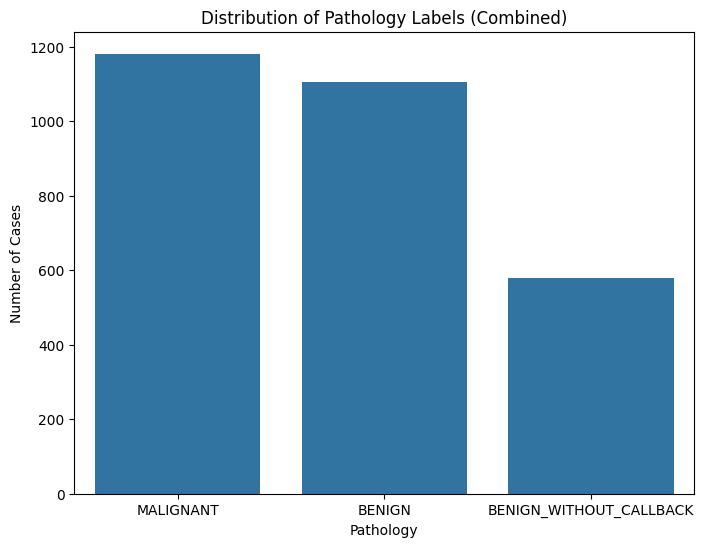

pathology
MALIGNANT                  1181
BENIGN                     1105
BENIGN_WITHOUT_CALLBACK     578
Name: count, dtype: int64


In [14]:
# Combine the pathology data from both dataframes
all_pathologies = pd.concat([df_mass['pathology'], df_calc['pathology']], ignore_index=True)

plt.figure(figsize=(8, 6))
sns.countplot(x=all_pathologies)
plt.title('Distribution of Pathology Labels (Combined)')
plt.ylabel('Number of Cases')
plt.xlabel('Pathology')
plt.show()

print(all_pathologies.value_counts())

# Key Observations :

1. Three Categories Exist: The dataset isn't just BENIGN and MALIGNANT. There is a third category, BENIGN_WITHOUT_CALLBACK. This typically refers to cases that are clearly and obviously benign, so much so that the patient doesn't even need a follow-up appointment.

2. Class Imbalance: The classes are not perfectly balanced.

    Malignant: ~1180 cases

    Benign: ~1100 cases

    Benign_Without_Callback: ~580 cases.
    <br><br><I>This isn't a severe imbalance, but it's present. The combined benign cases (BENIGN + BENIGN_WITHOUT_CALLBACK) outnumber the malignant cases.</I>

3. Binary classification or Multimodal Classification

## Comment on MASS_CASE_DESCRIPTION_TRAIN_SET

1. patient_id

        Decision: KEEP

        Reasoning: This is the primary identifier for each individual. It is essential for tracking, debugging, and potentially for grouping data for more advanced validation techniques (like group k-fold cross-validation) to ensure that all images from a single patient stay in the same train/test split.

2. image file path

        Decision: KEEP

        Reasoning: This is the direct link to our primary data source—the full mammogram images. It is the most critical column for our image processing pipeline.

3. breast_density

        Decision: KEEP

        Reasoning: This is a high-impact clinical feature. Breast density is a known risk factor for breast cancer and also affects the visibility of lesions on a mammogram. This provides crucial context that the model can learn from. It will be one-hot encoded.

4. left or right breast (Laterality)

        Decision: KEEP

        Reasoning: Provides essential spatial context. The model can learn if there are any side-specific anatomical patterns. Most importantly, it's a fundamental piece of data that a human radiologist always uses.

5. image view (e.g., CC, MLO)

        Decision: KEEP

        Reasoning: Provides essential orientational context. The appearance of anatomical structures and lesions can differ significantly between views. Keeping this helps the model interpret the 2D image correctly.

6. abnormality type

        Decision: KEEP

        Reasoning: When we combine the mass and calc dataframes, this feature becomes a powerful discriminator. It explicitly tells the model whether the primary finding is a mass or a calcification, allowing it to prime its visual feature extractors accordingly.

7. pathology

        Decision: ENGINEER

        Reasoning: This is our ground truth target. We will not keep the column in its raw string format ('MALIGNANT', 'BENIGN'). Instead, we will engineer it into a final binary label column (1 for Malignant, 0 for Benign), which is what the model will be trained to predict.

8. mass shape & mass margins

        Decision: DROP

        Reasoning:

            Missing Data: Our exploration showed these columns contain null values, requiring complex imputation.

            High Complexity: They contain numerous composite categories (e.g., LOBULATED-IRREGULAR) that would need advanced parsing and feature engineering.

            Data Leakage Risk: These are subjective interpretations by a radiologist. Forcing our CNN to learn these visual features from the pixels is a more robust and generalizable approach.

9. assessment & subtlety

        Decision: DROP

        Reasoning: Critical Data Leakage. These columns represent the radiologist's final judgment on the case's difficulty and suspicion level (BI-RADS assessment). Including them would cause the model to "cheat" by learning these scores instead of learning from the image data, leading to an artificially inflated performance that would not translate to real-world use.

10. abnormality id

        Decision: DROP

        Reasoning: This is a non-predictive identifier used for internal bookkeeping within the dataset. It provides no generalizable information for the model to learn from.

11. cropped image file path & ROI mask file path

        Decision: DROP

        Reasoning: These are redundant for our specific project design. Our PatchExtractor with automated tissue detection is designed to find these regions of interest from the full image dynamically. This makes our solution more robust and less dependent on pre-supplied masks, which may not be available in a real-world scenario.

In [15]:
df_calc.head(3)

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...


In [16]:
df_calc.columns

Index(['patient_id', 'breast density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'calc type', 'calc distribution',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')

# Comment on CALC_CASE_DESCRIPTION_TRAIN_SET

1. patient_id, image file path, breast_density, left or right breast, image view, abnormality type:

        Decision: KEEP

        Reasoning: Same as before. These are essential identifiers and high-impact clinical features.

2. pathology:

        Decision: ENGINEER

        Reasoning: Same as before. We will convert this to our binary label column.

3. calc type & calc distribution:

        Decision: DROP

        Reasoning: These are the "calcification" equivalents of mass shape and mass margins. They suffer from the exact same issues:

            High Complexity & Missing Values: They often contain complex, composite descriptions and can have missing data.

            Data Leakage Risk: They represent a radiologist's interpretation of the visual data. It is far more robust to have our CNN learn to identify these patterns (e.g., "pleomorphic," "linear," "clustered") directly from the image pixels.

4. assessment, subtlety, abnormality id, cropped image file path, ROI mask file path:

        Decision: DROP

        Reasoning: Same as before. These columns either represent a critical data leak (assessment, subtlety), are non-predictive identifiers (abnormality id), or are made redundant by our superior PatchExtractor pipeline (cropped image file path, ROI mask file path).

In [17]:
df_dicom.head(3)

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0


In [18]:
df_dicom.columns

Index(['file_path', 'image_path', 'AccessionNumber', 'BitsAllocated',
       'BitsStored', 'BodyPartExamined', 'Columns', 'ContentDate',
       'ContentTime', 'ConversionType', 'HighBit', 'InstanceNumber',
       'LargestImagePixelValue', 'Laterality', 'Modality', 'PatientBirthDate',
       'PatientID', 'PatientName', 'PatientOrientation', 'PatientSex',
       'PhotometricInterpretation', 'PixelRepresentation',
       'ReferringPhysicianName', 'Rows', 'SOPClassUID', 'SOPInstanceUID',
       'SamplesPerPixel', 'SecondaryCaptureDeviceManufacturer',
       'SecondaryCaptureDeviceManufacturerModelName', 'SeriesDescription',
       'SeriesInstanceUID', 'SeriesNumber', 'SmallestImagePixelValue',
       'SpecificCharacterSet', 'StudyDate', 'StudyID', 'StudyInstanceUID',
       'StudyTime'],
      dtype='object')

# comment on DICOM_INFO

Columns to KEEP (Temporarily for Merging & Engineering)

1. image_path

        Decision: KEEP (as Merge Key)

        Reasoning: This is the most important column. It's the unique key we will use to merge this dataframe with our training dataframes (df_mass and df_calc). After the merge, it becomes redundant and can be dropped.

2. PatientID

        Decision: KEEP

        Reasoning: Consistent patient identifier. While we already have patient_id in the training files, keeping this one allows us to verify that the merge was correct. It's our primary subject identifier.

3. StudyDate & PatientBirthDate

        Decision: ENGINEER

        Reasoning: These two columns are not used directly. Their sole purpose is to be combined to engineer our critical patient_age feature. Once patient_age is created, these raw date columns can be dropped.

Columns to DROP (The Vast Majority)

1. file_path

        Decision: DROP

        Reasoning: Redundant. The image_path column already provides the necessary link to the image files.

2. AccessionNumber, StudyID, StudyInstanceUID, SeriesInstanceUID, SOPInstanceUID, SOPClassUID, InstanceNumber, SeriesNumber

        Decision: DROP

        Reasoning: These are all various levels of DICOM-specific identifiers for the study, series, and image instance. They are crucial for hospital PACS systems but are non-predictive for our machine learning task. PatientID is the only identifier we need.

3. BitsAllocated, BitsStored, HighBit, PixelRepresentation, SamplesPerPixel, PhotometricInterpretation, ConversionType

        Decision: DROP

        Reasoning: These columns describe the technical details of pixel encoding. Our image processing pipeline (using libraries like pydicom and OpenCV) handles these details automatically when it loads the image into a NumPy array. They have no direct predictive value for the model.

4. Columns, Rows

        Decision: DROP

        Reasoning: Describes the dimensions of the image. Our model will get this information directly from the shape of the input tensors. Furthermore, since all our global images will be resized to a fixed size (e.g., 128x128), the original dimensions are not needed.

5. ContentDate, ContentTime, StudyTime

        Decision: DROP

        Reasoning: Redundant time/date information. StudyDate is the only one we need (for age calculation).

6. BodyPartExamined, Modality, PatientSex

        Decision: DROP

        Reasoning: Low-to-Zero Variance. For this specific dataset, BodyPartExamined will always be 'BREAST', Modality will always be 'MG' (Mammography), and PatientSex will always be 'F'. A column with only one value provides no information for the model to learn from.

7. PatientName, ReferringPhysicianName

        Decision: DROP

        Reasoning: Personally Identifiable Information (PII) and high cardinality text data. This should never be used as a feature.

8. Laterality

        Decision: DROP (from this file)

        Reasoning: This is a tricky one. While laterality is important, we are already getting this information from the more reliable left or right breast column in the primary training CSVs. Keeping both would be redundant. We will trust the label in the ground-truth training file.

9. All other columns (e.g., PatientOrientation, SmallestImagePixelValue, SecondaryCaptureDeviceManufacturer, etc.)

        Decision: DROP

        Reasoning: These represent additional technical or non-predictive metadata that does not contribute to the core task of classifying a lesion as benign or malignant.

In [20]:
df_meta.head(3)

,SeriesInstanceUID,StudyInstanceUID,Modality,SeriesDescription,BodyPartExamined,SeriesNumber,Collection,Visibility,ImageCount
0,1.3.6.1.4.1.9590.100.1.2.117041576511324414842...,1.3.6.1.4.1.9590.100.1.2.229361142710768138411...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
1,1.3.6.1.4.1.9590.100.1.2.438738396107617880132...,1.3.6.1.4.1.9590.100.1.2.195593486612988388325...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
2,1.3.6.1.4.1.9590.100.1.2.767416741131676463382...,1.3.6.1.4.1.9590.100.1.2.257901172612530623323...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2


In [21]:
df_meta.columns

Index(['SeriesInstanceUID', 'StudyInstanceUID', 'Modality',
       'SeriesDescription', 'BodyPartExamined', 'SeriesNumber', 'Collection',
       'Visibility', 'ImageCount'],
      dtype='object')

# comment on META

1. SeriesInstanceUID, StudyInstanceUID

        Decision: DROP

        Reasoning: These are high-level DICOM identifiers for grouping series and studies. While essential for organizing data in a clinical setting, we already have a more direct way to link our data (image_path to patient_id). Using these for merging would add unnecessary complexity with no additional benefit for our specific task.

2. Modality, BodyPartExamined, Collection

        Decision: DROP

        Reasoning: Zero-to-Low Variance. These columns describe the entire dataset. Modality is 'MG', BodyPartExamined is 'BREAST', and Collection is likely 'CBIS-DDSM'. As these values are constant across all relevant rows, they offer no predictive power.

3. SeriesDescription

        Decision: DROP

        Reasoning: Redundant Information. This column contains text like "right MLO" or "left CC". This information is already available in a cleaner, structured format in the left or right breast and image view columns of our core training CSVs. Using the structured data is far more reliable than parsing this text field.

4. SeriesNumber

        Decision: DROP

        Reasoning: Non-Predictive Identifier. This is a number assigned to a series within a study (e.g., Series 1, Series 2). It has no correlation with the pathology of the images within it.

5. Visibility, ImageCount

        Decision: DROP

        Reasoning: Non-Clinical Metadata. Visibility likely refers to the public status of the data, and ImageCount is the number of images in the series. Neither of these is a biological or clinical feature of the patient or the finding. Our model is designed to classify a single image based on its own content, not based on how many other images were taken in the same session.

Overall Conclusion for meta.csv:

After a thorough review, we can conclude that the meta.csv file is not required for our project.

It contains high-level organizational metadata that is either:

1. Redundant: Its useful information is captured better in other files.

2. Non-Predictive: Its columns have constant values or are internal identifiers.

3. Non-Clinical: It describes the dataset's structure, not patient pathology.

In [29]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import glob # Library to find files matching a pattern

# ==============================================================================
# Your excellent ImagePathFixerSimple class, integrated directly
# ==============================================================================
class ImagePathFixerSimple:
    def __init__(self, all_image_paths: list):
        self.full_lookup = self._build_lookup(all_image_paths)

    def _build_lookup(self, paths: list) -> dict:
        lookup = {}
        for path in paths:
            try:
                # The key is the parent directory name (the long UID)
                key = Path(path).parts[-2]
                lookup[key] = str(path)
            except Exception as e:
                print(f"[!] Lookup build error on path '{path}': {e}")
        print(f"✅ Built path lookup dictionary with {len(lookup)} entries.")
        return lookup

    def fix_paths_in_df(self, df: pd.DataFrame, col_to_fix: str) -> pd.DataFrame:
        """Fixes the paths in a specific dataframe column."""
        # We apply the _fix_path method to the specified column
        df[col_to_fix] = df[col_to_fix].apply(lambda p: self._fix_path(p))
        return df

    def _fix_path(self, path_str: str) -> str:
        """Looks up the correct path for a single given path string."""
        if pd.isna(path_str):
            return None
        try:
            # Extract the same key from the messy CSV path
            key = Path(path_str).parts[-2]
            # Return the correct path from the lookup, or None if not found
            return self.full_lookup.get(key, None)
        except Exception:
            return None

# ==============================================================================
# The rest of our processing script
# ==============================================================================

def scan_image_directory(base_path: str) -> list:
    """Recursively finds all JPEG image paths in the base directory."""
    print(f"Scanning for all JPEG images in: {base_path}")
    # The pattern '**/_*.jpg' recursively finds all jpg files.
    pattern = os.path.join(base_path, '**', '*.jpg')
    paths = glob.glob(pattern, recursive=True)
    print(f"Found {len(paths)} total JPEG images.")
    return paths

def load_and_combine_training_sets(mass_path: str, calc_path: str) -> pd.DataFrame:
    df_mass = pd.read_csv(mass_path)
    df_calc = pd.read_csv(calc_path)
    df_calc.rename(columns={'breast density': 'breast_density'}, inplace=True)
    df_train_combined = pd.concat([df_mass, df_calc], ignore_index=True)
    print("✅ Mass and Calc dataframes combined.")
    return df_train_combined

def merge_for_birthdate(df_train: pd.DataFrame, df_dicom: pd.DataFrame) -> pd.DataFrame:
    """Merges with dicom_info ONLY to get the patient birth date."""
    df_dicom['patient_id_key'] = df_dicom['PatientID'].str.extract(r'(P_\d{5})')
    dicom_patient_info = df_dicom[['patient_id_key', 'PatientBirthDate']].copy()
    dicom_patient_info.dropna(inplace=True)
    dicom_patient_info.drop_duplicates(subset=['patient_id_key'], inplace=True)
    
    df_master = pd.merge(df_train, dicom_patient_info, left_on='patient_id', right_on='patient_id_key', how='left')
    print("✅ Merged with dicom_info to get patient birth dates.")
    return df_master

def engineer_features_and_drop(df: pd.DataFrame) -> pd.DataFrame:
    """Engineers final features and drops all unnecessary columns."""
    # Engineer age
    df['StudyDate_proxy'] = pd.to_datetime('2016-01-01', errors='coerce')
    df['PatientBirthDate_dt'] = pd.to_datetime(df['PatientBirthDate'], format='%Y%m%d', errors='coerce')
    df['patient_age'] = (df['StudyDate_proxy'] - df['PatientBirthDate_dt']).dt.days / 365.25
    median_age = df['patient_age'].median()
    if pd.isna(median_age): median_age = 55
    df['patient_age'].fillna(median_age, inplace=True)

    # Engineer label
    df['label'] = df['pathology'].apply(lambda x: 1 if x == 'MALIGNANT' else 0)
    print(f"✅ Features 'patient_age' and 'label' engineered.")

    # Define all columns to drop
    columns_to_drop = [
        'abnormality id', 'assessment', 'subtlety', 'mass shape', 'mass margins',
        'calc type', 'calc distribution', 'cropped image file path', 'ROI mask file path',
        'patient_id_key', 'PatientBirthDate', 'PatientBirthDate_dt', 'StudyDate_proxy',
        'pathology'
    ]
    cols_dropped = [col for col in columns_to_drop if col in df.columns]
    df_cleaned = df.drop(columns=cols_dropped)
    print(f"✅ Dropped {len(cols_dropped)} unnecessary columns.")
    return df_cleaned

def main():
    """Main script execution function."""
    # --- Configuration ---
    # ** IMPORTANT: UPDATE THESE PATHS **
    DATA_DIR: str = "/home/beckett/Documents/k0d1ng/pinn-bcd/kaggle/data/cbis-ddsm-breast-cancer-image-dataset"
    CSV_DIR: str = DATA_DIR + "/csv"
    JPEG_DIR: str = DATA_DIR + "/jpeg"
    DICOM_PATH: str = CSV_DIR + "/dicom_info.csv"
    META_PATH: str = CSV_DIR + "/meta.csv"
    MASS_TRAIN_PATH: str = CSV_DIR + "/mass_case_description_train_set.csv"
    CALC_TRAIN_PATH: str = CSV_DIR + "/calc_case_description_train_set.csv"
    MASS_TEST_PATH: str = CSV_DIR + "/mass_case_description_test_set.csv"
    CALC_TEST_PATH: str = CSV_DIR + "/calc_case_description_test_set.csv"
    OUTPUT_CSV_PATH: str = CSV_DIR + "/final_training_set.csv"

    print("--- Starting CSV Preprocessing v3 (with PathFixer) ---")
    try:
        # 1. Scan disk for all real image paths
        # *** THE FIX IS HERE: Assign the result to the variable ***
        all_jpeg_paths = scan_image_directory(JPEG_DIR)

        # 2. Initialize your fixer with the real paths
        path_fixer = ImagePathFixerSimple(all_jpeg_paths)

        # 3. Load and combine the training CSVs
        df_train = load_and_combine_training_sets(MASS_TRAIN_PATH, CALC_TRAIN_PATH)

        # 4. FIX THE PATHS using your class
        df_train_fixed = path_fixer.fix_paths_in_df(df_train, col_to_fix='image file path')
        
        # Drop rows where the path could not be fixed
        original_rows = len(df_train_fixed)
        df_train_fixed.dropna(subset=['image file path'], inplace=True)
        print(f"Dropped {original_rows - len(df_train_fixed)} rows with unfixable paths.")

        # 5. Load dicom_info and merge for birth date
        df_dicom = pd.read_csv(DICOM_PATH)
        df_with_date = merge_for_birthdate(df_train_fixed, df_dicom)

        # 6. Engineer final features and drop junk columns
        df_final = engineer_features_and_drop(df_with_date)

        # 7. Save the final result
        df_final.to_csv(OUTPUT_CSV_PATH, index=False)
        print(f"\n🎉 --- Preprocessing Complete! --- 🎉")
        print(f"Cleaned data saved to: {os.path.abspath(OUTPUT_CSV_PATH)}")
        print(f"Final dataframe shape: {df_final.shape}")
        df_final.info()

    except Exception as e:
        print(f"❌ AN ERROR OCCURRED: {e}")
if __name__ == "__main__":
    main()

--- Starting CSV Preprocessing v3 (with PathFixer) ---
Scanning for all JPEG images in: /home/beckett/Documents/k0d1ng/pinn-bcd/kaggle/data/cbis-ddsm-breast-cancer-image-dataset/jpeg
Found 10237 total JPEG images.
✅ Built path lookup dictionary with 6774 entries.
✅ Mass and Calc dataframes combined.
Dropped 0 rows with unfixable paths.
✅ Merged with dicom_info to get patient birth dates.
✅ Features 'patient_age' and 'label' engineered.
✅ Dropped 14 unnecessary columns.

🎉 --- Preprocessing Complete! --- 🎉
Cleaned data saved to: /home/beckett/Documents/k0d1ng/pinn-bcd/kaggle/data/cbis-ddsm-breast-cancer-image-dataset/csv/final_training_set.csv
Final dataframe shape: (2864, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   patient_id            2864 non-null   object 
 1   breast_density        2864 non-null   int64  
 2   l

/home/beckett/Documents/k0d1ng/pinn-bcd/venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/tmp/ipykernel_5720/404058792.py:84: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['patient_age'].fillna(median_age, inplace=True)


In [31]:
df_dicom["PatientBirthDate"].unique()

array([nan])